<a href="https://colab.research.google.com/github/k99885/dacon2024_bird_lowres_image_classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm import tqdm
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array,array_to_img,ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Activation,Dropout
import matplotlib.pyplot as plt
from keras.utils import Sequence
from sklearn import preprocessing
import tensorflow as tf
from keras.optimizers import Adam,RMSprop,AdamW
from keras.applications import *
from keras import Model,regularizers
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
file='/content/drive/MyDrive/dataset/birds'
t_csv='train.csv'
t_csv=os.path.join(file,t_csv)
print(t_csv)
df = pd.read_csv(t_csv)


/content/drive/MyDrive/dataset/birds/train.csv


In [ ]:
image_paths= df["upscale_img_path"]
le = preprocessing.LabelEncoder()
train_labels_encoded = le.fit_transform(df['label'])
df['label'] = train_labels_encoded

labels = df['label']
print(labels)
train_image_paths = image_paths.str.replace('./', '')  # "./" 제거
full_image_paths = [os.path.join(file, img_path) for img_path in train_image_paths]

full_image_paths = pd.Series(full_image_paths, name='Filepath').astype(str)

image_df = pd.concat([full_image_paths, labels], axis=1)


0        19
1         9
2        13
3         3
4         3
         ..
15829     4
15830     3
15831     2
15832    19
15833     8
Name: label, Length: 15834, dtype: int64


<ipython-input-5-ade074999321>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


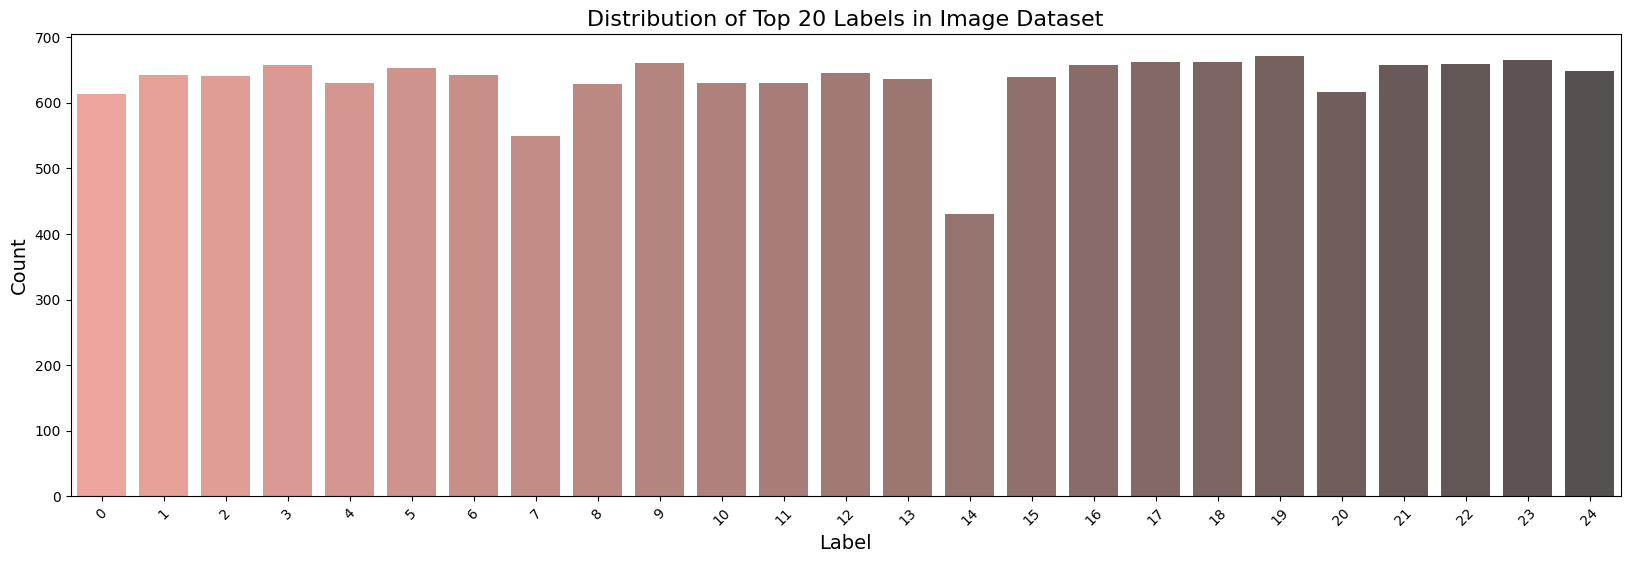

In [ ]:
# Get the top 20 labels
label_counts = image_df['label'].value_counts()[:25]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [ ]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
train_df, val_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
print("all:",len(image_df))
print("train_set:",len(train_df))
print("val_set",len(val_df))


all: 15834
train_set: 12667
val_set 3167


In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=10,
    horizontal_flip=True
)
val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    )

In [ ]:
TARGET_SIZE=(256,256)
BATCH_SIZE=64
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="lanczos" # 보간 방법 설정

)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="lanczos" # 보간 방법 설정


)

Found 12667 validated image filenames.
Found 3167 validated image filenames.


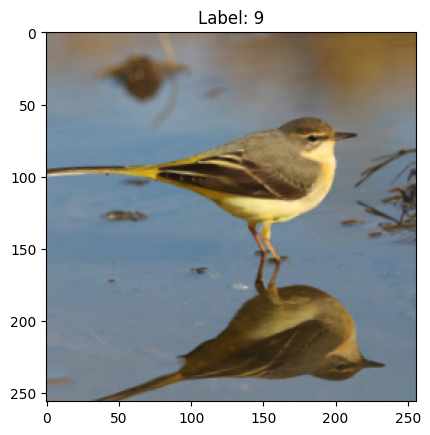

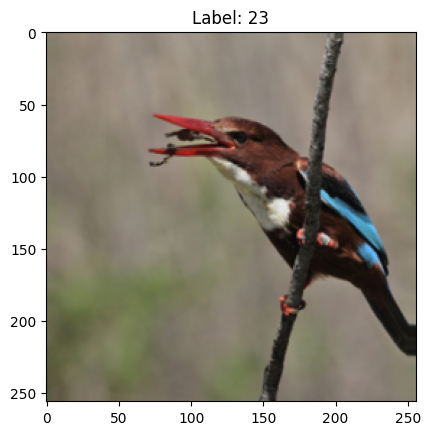

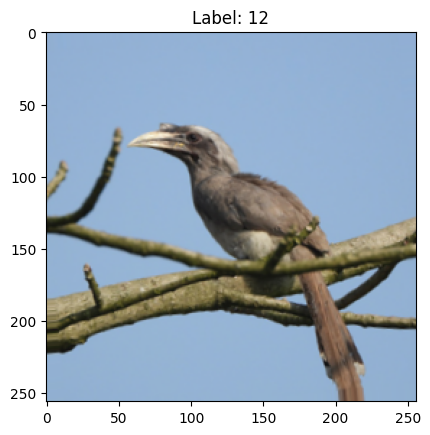

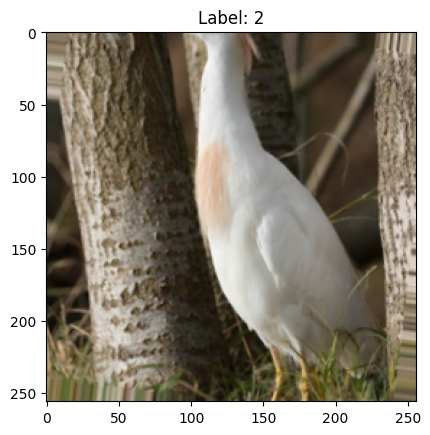

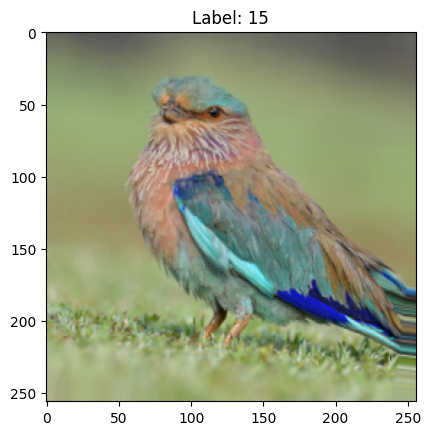

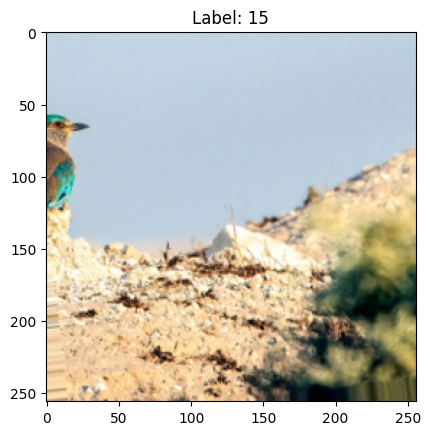

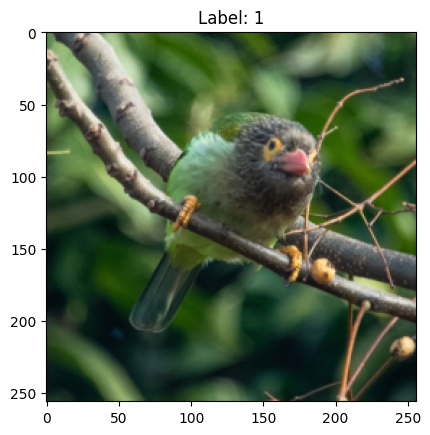

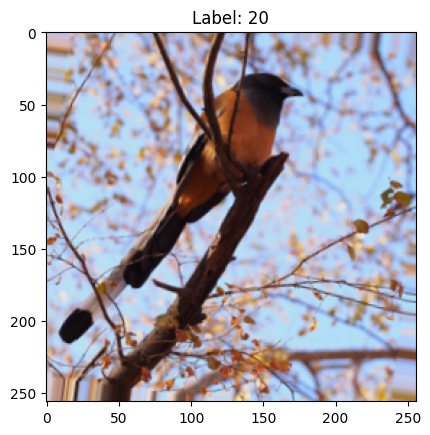

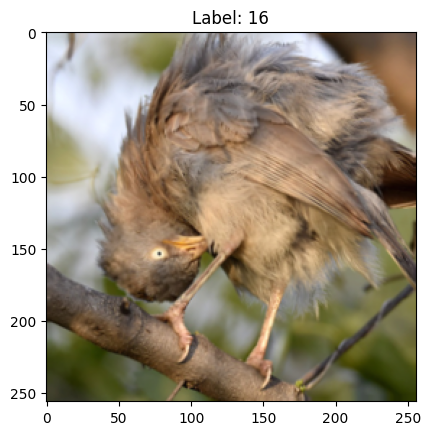

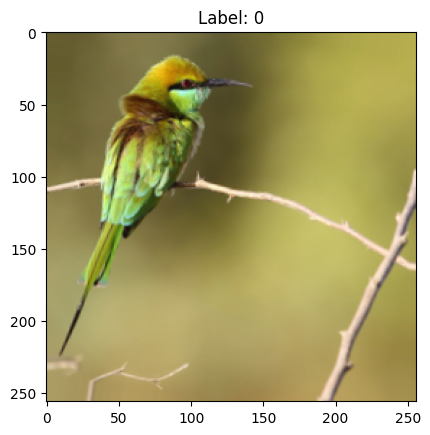

In [ ]:
images, labels = train_images.next()

# 이미지와 레이블 출력
for i in range(10):
    image = images[i]
    image = image.astype('uint8')

    label = labels[i]
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()

In [ ]:
pretrained_model = tf.keras.applications.EfficientNetV2B3 (
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

52606240/52606240 [==============================] - 0s 0us/step


In [ ]:
inputs = layers.Input(shape = (256,256,3), name='inputLayer')
pretrain_out = pretrained_model(inputs, training = False)
initializer = tf.keras.initializers.HeNormal()  # He 초기화 객체 생성

x = layers.Dense(256,kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.0001))(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(25)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=Adam(0.1),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 1536)              12930622  
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0   

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

CALLBACKS = [early_stopping_callback, reduce_lr_callback]

In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=CALLBACKS
)

Epoch 1/10
198/198 [==============================] - 305s 2s/step - loss: 1.0207 - accuracy: 0.9649 - val_loss: 0.9776 - val_accuracy: 0.9747 - lr: 1.0000e-03
Epoch 2/10
198/198 [==============================] - 304s 2s/step - loss: 0.9873 - accuracy: 0.9659 - val_loss: 1.0573 - val_accuracy: 0.9454 - lr: 1.0000e-03
Epoch 3/10
198/198 [==============================] - 298s 2s/step - loss: 0.9555 - accuracy: 0.9700 - val_loss: 0.9385 - val_accuracy: 0.9751 - lr: 1.0000e-03
Epoch 4/10
198/198 [==============================] - 297s 1s/step - loss: 0.9277 - accuracy: 0.9706 - val_loss: 0.9178 - val_accuracy: 0.9738 - lr: 1.0000e-03
Epoch 5/10
198/198 [==============================] - 296s 1s/step - loss: 0.9011 - accuracy: 0.9710 - val_loss: 0.9075 - val_accuracy: 0.9716 - lr: 1.0000e-03
Epoch 6/10
198/198 [==============================] - 298s 2s/step - loss: 0.8697 - accuracy: 0.9746 - val_loss: 0.8741 - val_accuracy: 0.9751 - lr: 1.0000e-03
Epoch 7/10
198/198 [====================

In [ ]:
model.save('/content/drive/MyDrive/dataset/birds/birds_4')

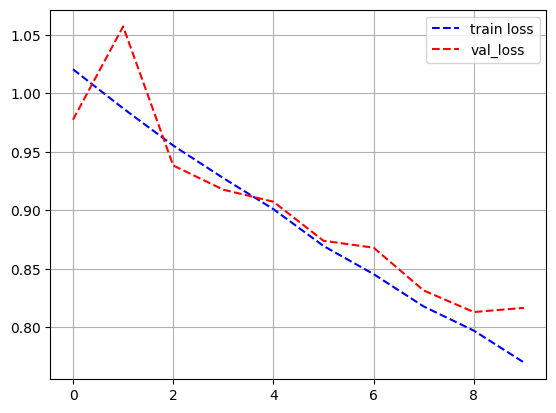

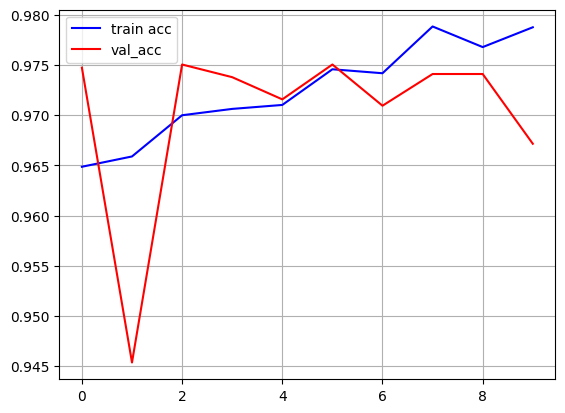

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))
plt.plot(epochs,loss,'b--',label='train loss')
plt.plot(epochs,val_loss,'r--',label='val_loss')
plt.grid()
plt.legend()
plt.show()

plt.plot(epochs,acc,'b-',label='train acc')
plt.plot(epochs,val_acc,'r-',label='val_acc')
plt.grid()
plt.legend()

plt.show()

In [ ]:

#test
file='/content/drive/MyDrive/dataset/birds'
test_csv='test.csv'
test_csv=os.path.join(file,test_csv)
print(test_csv)
test = pd.read_csv(test_csv)



/content/drive/MyDrive/dataset/birds/test.csv


In [ ]:
test_image_paths = test["img_path"]
test_image_paths = test_image_paths.str.replace('./', '')  # "./" 제거
test_full_image_paths = [os.path.join(file, img_path) for img_path in test_image_paths]

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

test_full_image_paths = pd.Series(test_full_image_paths, name='Filepath').astype(str)

test_df = pd.concat([test_full_image_paths], axis=1)

TARGET_SIZE=(64,64)
BATCH_SIZE=32

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col=None,  # 레이블이 없음
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode=None,  # 레이블이 없음
    batch_size=BATCH_SIZE,
    shuffle=False,
    interpolation="bicubic" # 보간 방법 설정

)


Found 6786 validated image filenames.


In [ ]:
images = test_images.next()

# 이미지와 레이블 출력
for i in range(5):
    image = images[i]
    image = image.astype('uint8')
    plt.imshow(image)
    plt.show()

In [ ]:
def inference(model, test_images):
    preds = []
    pred = model.predict(test_images)
    preds += np.argmax(pred, axis=1).tolist()

    return preds

preds = inference(model, predicted_test_images)


NameError: name 'predicted_test_images' is not defined

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/birds/sample_submission.csv')
submit['label'] = le.inverse_transform(preds)
submit.to_csv('/content/drive/MyDrive/dataset/birds/sample_submission4_3_up.csv', index=False)
